<a href="https://colab.research.google.com/github/MarcosLaydner/ds_repo/blob/master/Assignment_1/CE888_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Enviroment preparation

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from google.colab import files
from zipfile import ZipFile
import matplotlib.pyplot as plt


In [0]:
# Install Kaggle library
!pip install -q kaggle

# Upload kaggle API key file if needed
# uploaded = files.upload()

# moves json file so the download commands works properly
!cp kaggle.json ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


# Dataset download, storage and preprocessing

In [0]:
!kaggle competitions download -c santander-customer-transaction-prediction --force

santander_train = pd.read_csv('train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
santander_test = pd.read_csv('test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

!kaggle competitions download -c sberbank-russian-housing-market --force

zip_file = ZipFile('train.csv.zip')
housing_train = pd.read_csv(zip_file.open('train.csv'))
zip_file = ZipFile('test.csv.zip')
housing_test = pd.read_csv(zip_file.open('test.csv'))

  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 64.1MB/s]
 91% 113M/125M [00:00<00:00, 93.0MB/s] 
100% 125M/125M [00:01<00:00, 122MB/s] 
 84% 105M/125M [00:01<00:00, 95.8MB/s] 
100% 125M/125M [00:01<00:00, 112MB/s] 
  0% 0.00/25.4k [00:00<?, ?B/s]
100% 25.4k/25.4k [00:00<00:00, 19.5MB/s]
 53% 9.00M/17.1M [00:00<00:00, 62.6MB/s]
100% 17.1M/17.1M [00:00<00:00, 83.8MB/s]
  0% 0.00/66.5k [00:00<?, ?B/s]
100% 66.5k/66.5k [00:00<00:00, 134MB/s]
  0% 0.00/4.46M [00:00<?, ?B/s]
100% 4.46M/4.46M [00:00<00:00, 73.5MB/s]
  0% 0.00/18.6k [00:00<?, ?B/s]
100% 18.6k/18.6k [00:00<00:00, 16.9MB/s]


In [0]:
def missing_data_treatment(data):
  for i in data.columns:
    if data[i].dtype == 'object':
      data[i] = data[i].fillna(data[i].mode().iloc[0])
    if (data[i].dtype == 'int' or data[i].dtype == 'float'):
      data[i] = data[i].fillna(np.mean(data[i]))

def label_encoding(data, encoder):
  for i in data.columns:
    if (data[i].dtype == 'object'):
      data[i] = encoder.fit_transform(data[i].astype('str'))
      data[i] = data[i].astype('object')

In [0]:
missing_data_treatment(housing_train)
missing_data_treatment(housing_test)

number = LabelEncoder()
label_encoding(housing_train, number)
label_encoding(housing_test, number)

In [0]:
housing_train

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,30469,2015-06-30,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,3.0,Investment,Otradnoe,1.005305e+07,175518,0.096270,0.300323,9753,5088.0,4,10311,12721.0,4,0,NaN,1,0,10,3,no,0,9,6,no,yes,no,yes,no,no,no,...,647.89,1112.68,880.28,8,20,30,15,5,1,0,5,12,1,0,29,3,15.52,17.24,44,838601,53,2548292,207,689.95,1156.08,923.02,18,63,59,47,15,5,0,15,26,1,2,84,6,7400000
30467,30470,2015-06

In [0]:
santander_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


# Functions for checking Covariate Shift

In [0]:
def compare_train_test_distribution(train, test, col):  
  N_points = 100000
  n_bins = 20

  y = train[col]
  x = test[col]

  fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

  # We can set the number of bins with the `bins` kwarg
  axs[0].hist(x, bins=n_bins)
  axs[1].hist(y, bins=n_bins)

def concat(train_df, test_df, id_column, y):
  train_df.drop(columns=[id_column, y], inplace=True)
  test_df.drop(columns=[id_column], inplace=True)

  train_df['is_test'] = 0
  test_df['is_test'] = 1
  df = pd.concat([train_df, test_df], axis = 0)
  return df

def shuffle_split(df):
  X = df.drop(columns=['is_test'])
  y = df['is_test']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
  print('train2 shape:', X_train.shape, 'test2 shape:', X_test.shape)
  return X_train, X_test, y_train, y_test


def test_shift(X_train, X_test, y_train, y_test):
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)

  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

# Applying the functions to the data

train2 shape: (280000, 200) test2 shape: (120000, 200)
AUC score:  0.5017


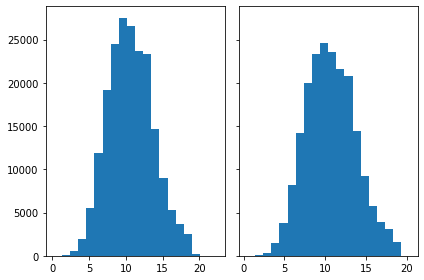

In [0]:
# # Applying to santander set
# compare_train_test_distribution(santander_train, santander_test, 'var_0')

# concat_df = concat(santander_train, santander_test, 'ID_code', 'target')
# param = shuffle_split(concat_df)

# test_shift(param[0], param[1], param[2], param[3])

with a score of around 0.5, it is safe to assume minimun to no covariate shift

train2 shape: (26693, 290) test2 shape: (11440, 290)
AUC score:  1.0


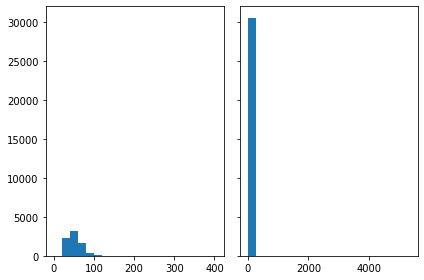

In [0]:
# Applying to housing set
housing_train_c = housing_train.copy()
housing_test_c = housing_test.copy()

compare_train_test_distribution(housing_train_c, housing_test_c, 'full_sq')

concat_df = concat(housing_train_c, housing_test_c, 'id', 'price_doc')
param = shuffle_split(concat_df)

test_shift(param[0], param[1], param[2], param[3])

score of 1.0 indicating total shift

# Identifying problematic features

In [0]:
y = concat_df['is_test']
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
drop_list = []
for i in concat_df.columns:
  score = cross_val_score(model,pd.DataFrame(concat_df[i]),y,cv=2,scoring='roc_auc')
  if (np.mean(score) > 0.8):
    drop_list.append(i)
    print(i,np.mean(score))
drop_list

life_sq 0.800161853422417
kitch_sq 0.8454682441425382
hospital_beds_raion 0.8758045464232334
cafe_sum_500_min_price_avg 0.8308835202409928
cafe_sum_500_max_price_avg 0.8306016861773655
cafe_avg_price_500 0.829205884203281
is_test 1.0


['life_sq',
 'kitch_sq',
 'hospital_beds_raion',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'is_test']

# Determining the importance of the drifting features

In [0]:
rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
rf.fit(housing_train.drop('price_doc',axis=1),housing_train['price_doc'])
pred = rf.predict(housing_test)
columns = ['price_doc']
sub = pd.DataFrame(data=pred,columns=columns)
sub['id'] = housing_test['id']
sub = sub[['id','price_doc']]
sub.to_csv('with_drifting.csv', index=False)

# !kaggle competitions submit -c sberbank-russian-housing-market -f with_drifting.csv -m "with drifting"

RMSE of the submitted model with drifting is 0.40540

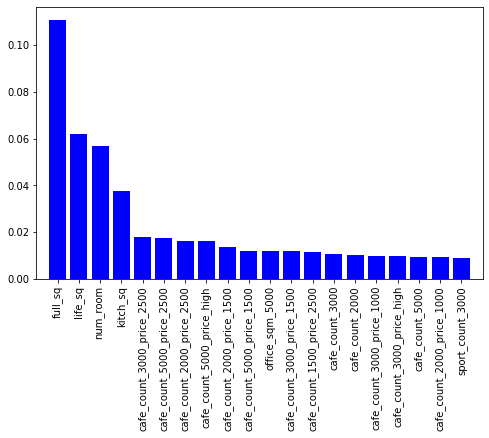

In [0]:
features = housing_train.drop('price_doc',axis=1).columns.values
imp = rf.feature_importances_
indices = np.argsort(imp)[::-1][:20]

#plot
plt.figure(figsize=(8,5))
plt.bar(range(len(indices)), imp[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

This way, it is possible to conclude that among the 4 most important features, two are in the drifting list

## Testing the performance without the problem features

In [0]:
# drop_list.remove('is_test')
drift_train = housing_train.drop(columns=drop_list)
drift_test = housing_test.drop(columns=drop_list)

rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
rf.fit(drift_train.drop('price_doc',axis=1),housing_train['price_doc'])
pred = rf.predict(drift_test)
columns = ['price_doc']
sub = pd.DataFrame(data=pred,columns=columns)
sub['id'] = housing_test['id']
sub = sub[['id','price_doc']]
sub.to_csv('without_drifting.csv', index=False)

!kaggle competitions submit -c sberbank-russian-housing-market -f without_drifting.csv -m "without drifting"

100% 180k/180k [00:02<00:00, 91.1kB/s]
Successfully submitted to Sberbank Russian Housing Market

The score for this one was 0.41349, worse than the one with the drifting feature

## Removing only the non-important drifting features

In [0]:
# drop_list.remove('life_sq')
# drop_list.remove('kitch_sq')

drift_train = housing_train.drop(columns=drop_list)
drift_test = housing_test.drop(columns=drop_list)

rf = RandomForestRegressor(n_estimators=200, max_depth=6,max_features=10)
rf.fit(drift_train.drop('price_doc',axis=1),housing_train['price_doc'])
pred = rf.predict(drift_test)
columns = ['price_doc']
sub = pd.DataFrame(data=pred,columns=columns)
sub['id'] = housing_test['id']
sub = sub[['id','price_doc']]
sub.to_csv('without_uninportant_drifting.csv', index=False)

!kaggle competitions submit -c sberbank-russian-housing-market -f without_uninportant_drifting.csv -m "without_uninportant_drifting"

100% 180k/180k [00:01<00:00, 181kB/s]
Successfully submitted to Sberbank Russian Housing Market

The score now dropped to 0.39996, a small improvement, but a improvement nonetheless